### Installations

In [1]:
#!pip install lxml
#!pip install wget
#!pip install gpxpy

### Imports

In [110]:
# import requests
import re
from bs4 import BeautifulSoup 
import pandas as pd
import lxml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

import requests
#import wget
import glob
import datetime as dt
import time
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time
import gpxpy 
import gpxpy.gpx 
import glob

# Still to do:
- Add key words: Webscraping from a static page, Data Cleaning, plots, plotly?, GPX coordinates, KML coordinates (add both? describe the differences?), spatial data, tableau, visualization, seaboarn, matplotlib

- DONE with functions: import csv file instead of rescrapping (hash out the rest)

- DONE: change difficulty to '0 - No rating', '1 - Easy' etc
- DONE for corr matrix: remove '0 - No rating' for some plots
- DONE: easy = green etc
- WIP - let me know if any idea of design...:nicer look of plots?

- DONE: create function for gpx part
- simplify gpx code
- run gpx code for all 257 codes (check if not blocked)

- check why datetime code does not always work

- Check comment with Google earth and "KML" file

# 1  Data scraping

Prepare to scrape the Bergfex.com website in order to create Pandas dataframes that contain important information about each trail. This code uses BeautifulSoup to parse the html tags into json, which is easier to work with. A for-loop iterates over each html tag and adds the corresponding information into empty lists. 

### 1.1 Scrape all the information (basic and more complicated)

In [3]:
title = []  # Title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # Sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time_list = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)
total_title = [] # will help extracting the ID of the tour

# all ratings are stored together so we will need this along the way:
rating = []  # list to store technique and fitness rating info

In [4]:
# looping over the x first pages of Bergfex
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 2  # number of pages we want to scrape through

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])
        total_title.append(tour_title) 
        # this gets the full tour-title information including the ID, will need to be processed further later on
        
        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time_list.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2


In [5]:
print("number of tours collected:", len(title))

number of tours collected: 40


### 1.2 Extracting embedded HTML tags: <a href="" 
Each trail name and ID was used in Bergfex's URL. Using the trail ID in the dataframe will provide a unique ID to use later in the analysis. However, those two data points are embedded deeper in the html code. The below codes shows how to extract the datapoints into a dataframe.

In [6]:
# Extracting the ID via the URL
links_title = []

for i in total_title:
    i = str(i)
    i = i.strip('[]')
    links_title.append(i)

In order to make the trail ID usable it needs to be cleaned up and converted into a string

In [7]:
# Extracting ID
id_df3 = pd.DataFrame(links_title)
id_df2 = id_df3[0].str.split(' ',expand = True)
id_df1 = id_df2[2].str.split(',',expand = True)
id_df = id_df1[0].str.split('/',expand = True)

In [8]:
# from this format:
pd.options.display.max_colwidth = 100
id_df3.head()

,0
0,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/50431,auf-dem-jurahoehenweg/"" title=""Au..."
1,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/131685,via-alpina-lenk--gstaad/"" title=..."
2,"<a class=""h2"" href=""/sommer/bern-region/touren/radfahren/717203,boltigen--feuersteini--rossberg-..."
3,"<a class=""h2"" href=""/sommer/bern-region/touren/themenweg/99380,stockentaler-hausweg--blumenstein..."
4,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/586723,rundtour-auf-abenteuerlichen-weg..."


In [9]:
# to this format:
id_df.head()

,0,1,2,3,4,5
0,"href=""",sommer,bern-region,touren,wanderung,50431
1,"href=""",sommer,bern-region,touren,wanderung,131685
2,"href=""",sommer,bern-region,touren,radfahren,717203
3,"href=""",sommer,bern-region,touren,themenweg,99380
4,"href=""",sommer,bern-region,touren,wanderung,586723


### 1.3 Extracting embedded HTML tags: <Div class=""
The HTML tags for the fitness and technique ratings were embedded within Div class tags; they are extracted using a for-loop and then stripped of unecessary characeters. 
- Convert the tour rating tag into a string
- Strip away unecessary characters 
- Split into lists which look like rating_list [Technique, Fitness]
- Finally, convert into seperate lists for Technique and Fitness

In [10]:
rating[0] # View the emmbedded DIV tag

[<div class="tour-rating">
 <div class="tour-rating-label">Technique</div>
 <div class="rating-circles rating-max6"><div class="rating-4"></div></div>
 </div>,
 <div class="tour-rating">
 <div class="tour-rating-label">Fitness</div>
 <div class="rating-circles rating-max6"><div class="rating-5"></div></div>
 </div>]

In [11]:
# Replace unwanted information
tour_rating_str = str(rating)
rating_all_short = tour_rating_str.replace(
'<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
).replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')
rating_list = rating_even_shorter.split(", ")

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # add first item in technique
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other appended to fitness list

In [12]:
## Let's look at the result

#rating_all_short
#rating_even_shorter
rating_list

['rating-4',
 'rating-5',
 'rating-2',
 'rating-6',
 'rating-1',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-4',
 'rating-3',
 'rating-3',
 'rating-4',
 'rating-2',
 'rating-3',
 'rating-',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-1',
 'rating-2',
 'rating-1',
 'rating-1',
 'rating-5',
 'rating-5',
 'rating-3',
 'rating-4',
 'rating-2',
 'rating-1',
 'rating-',
 'rating-1',
 'rating-1',
 'rating-4',
 'rating-1',
 'rating-1',
 'rating-1',
 'rating-1',
 'rating-1',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-4',
 'rating-',
 'rating-0',
 'rating-',
 'rating-0',
 'rating-5',
 'rating-6',
 'rating-1',
 'rating-1',
 'rating-1',
 'rating-3',
 'rating-2',
 'rating-3',
 'rating-3',
 'rating-3',
 'rating-2',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-1',
 'rating-2',
 'rating-',
 'rating-4',
 'rating-3',
 'rating-4',
 'rating-5',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-1',
 'rating-2',
 'rating-3',
 'rating-3',
 'rating-1',
 'rating-1',
 'rating-2',
 'rat

### 1.4  Create dataframe for extracted elements

This dataframe is not in the final stage yet as there are still extra brackets, the minimum and maximum elevation are still in one column, and units must be stripped away

In [13]:
activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
activities_df_unclean

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Auf dem Jurahöhenweg],[difficult],[Hiking],18.32km,06:00h,"1,300hm","530 - 1,602m",rating-4,rating-5,50431
1,[Via Alpina: Lenk - Gstaad],[difficult],[Hiking],21.6km,07:30h,994hm,"1,049 - 2,059m",rating-2,rating-6,131685
2,[Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen],[easy],[Cycling],15.91km,01:25h,405hm,"797 - 1,136m",rating-1,rating-2,717203
3,[Stockentaler Hausweg - Blumenstein],[medium],[Thematic route],13.02km,03:30h,200hm,656 - 782m,rating-2,rating-3,99380
4,[Rundtour auf abenteuerlichen Wegen],[medium],[Hiking],5.9km,03:00h,630hm,"1,357 - 1,919m",rating-4,rating-3,586723
5,[Rellerli - Zum beliebten Ausflugsberg],[medium],[Hiking],9.59km,03:30h,630hm,"1,222 - 1,832m",rating-3,rating-4,50213
6,[Interlaken Ost - Harder Kulm],[medium],[Hiking],4.09km,02:30h,759hm,"566 - 1,322m",rating-2,rating-3,315061
7,[Basler Weg: Fraubrunnen - Bern (Variante A)],[medium],[Pilgrimage],24.48km,06:14h,160hm,489 - 570m,rating-,rating-3,277472
8,[Rund um den Moossee],[easy],[Hiking],6.47km,01:40h,90hm,521 - 571m,rating-2,rating-2,276223
9,[St. Stephan - Dürrewald - Eggmatte - St. Stephan],[easy],[Cycling],16.84km,02:15h,684hm,"993 - 1,669m",rating-1,rating-2,700234


### 1.5 Write CSV file of scrapped and uncleaned DF

In [14]:
activities_df_unclean.to_csv("../data/unclean_activities.csv", index=False)
activities_df_unclean

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Auf dem Jurahöhenweg],[difficult],[Hiking],18.32km,06:00h,"1,300hm","530 - 1,602m",rating-4,rating-5,50431
1,[Via Alpina: Lenk - Gstaad],[difficult],[Hiking],21.6km,07:30h,994hm,"1,049 - 2,059m",rating-2,rating-6,131685
2,[Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen],[easy],[Cycling],15.91km,01:25h,405hm,"797 - 1,136m",rating-1,rating-2,717203
3,[Stockentaler Hausweg - Blumenstein],[medium],[Thematic route],13.02km,03:30h,200hm,656 - 782m,rating-2,rating-3,99380
4,[Rundtour auf abenteuerlichen Wegen],[medium],[Hiking],5.9km,03:00h,630hm,"1,357 - 1,919m",rating-4,rating-3,586723
5,[Rellerli - Zum beliebten Ausflugsberg],[medium],[Hiking],9.59km,03:30h,630hm,"1,222 - 1,832m",rating-3,rating-4,50213
6,[Interlaken Ost - Harder Kulm],[medium],[Hiking],4.09km,02:30h,759hm,"566 - 1,322m",rating-2,rating-3,315061
7,[Basler Weg: Fraubrunnen - Bern (Variante A)],[medium],[Pilgrimage],24.48km,06:14h,160hm,489 - 570m,rating-,rating-3,277472
8,[Rund um den Moossee],[easy],[Hiking],6.47km,01:40h,90hm,521 - 571m,rating-2,rating-2,276223
9,[St. Stephan - Dürrewald - Eggmatte - St. Stephan],[easy],[Cycling],16.84km,02:15h,684hm,"993 - 1,669m",rating-1,rating-2,700234


###  1.6 Combine all in scraping function

To be able to repeat the same steps for a different region (for example "Wallis"), we put the scraping code into a function. Here we can choose the region, how many pages we want to scrape and whether we want to save the file as CSV.

In [15]:
def scraping_region(region, n_pages):
    title = []  # Title of the tour
    difficulty = []  # difficulty (easy, medium, hard)
    sport = []  # Sport type (hiking, sledging, snowshoe...)
    length = []  # length in km
    time_list = []  # tour time in hours:minutes
    climb = []  # positive elevation climb in m
    minmax = []  # minimum and maximum altitude of the tour in m
    total_title = [] # will help extracting the ID of the tour
    # all ratings are stored together so we will need this along the way:
    rating = []  # list to store technique and fitness rating info
    
    # looping over the x first pages of Bergfex
    # each separate tour on the page is framed by a div tag with 'touren-details'
    page_number = n_pages  # number of pages we want to scap through

    for p in range(1, (page_number+1)):
        base_link = f'https://www.bergfex.com/sommer/{region}/touren/?isAjax=1&page='
        link = base_link+str(p)  # going over p pages with numbers appended to the base link
        page = requests.get(link, timeout=5)
        print("scraped page", p)
        soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
        tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

    # For each page, we loop over each tour and fill our lists with info     
        for i in range(0,len(tours)):
            tour_1 = tours[i] # tour iterating over the 20 tours of the page

            tour_title = tour_1.findAll('a' ) # this gets the title out
            title.append([info.get_text().strip() for info in tour_title])
            total_title.append(tour_title) 
            # this gets the full tour-title information including the ID, processed further later on

            tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
            difficulty.append([info.get_text().strip() for info in tour_diff])

            tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
            sport.append([info.get_text().strip() for info in tour_type])

            tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
            stat_text = [info.get_text().strip() for info in tour_stats]
            length.append(stat_text[0])
            time_list.append(stat_text[1])
            climb.append(stat_text[2])
            minmax.append(stat_text[3])

            tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
            rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.
    print("number of tours collected:", len(title))
    return (title, difficulty, sport, length, time_list, climb, minmax, total_title, rating)

In [16]:
def extracting_id(total_title):
    
    links_title = []
    for i in total_title:
        i = str(i)
        i = i.strip('[]')
        links_title.append(i)
    # Extracting ID
    id_df3 = pd.DataFrame(links_title)
    id_df2 = id_df3[0].str.split(' ',expand = True)
    id_df1 = id_df2[2].str.split(',',expand = True)
    id_df = id_df1[0].str.split('/',expand = True)
    
    return id_df

In [17]:
def extracting_rating(rating):
    technique = []  # technique difficulty ratings (out of 6)
    fitness = []  # fitness difficulty ratings (out of 6)
    # Replace unwanted information
    tour_rating_str = str(rating)
    rating_all_short = tour_rating_str.replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
    ).replace(
        '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
    rating_even_shorter = rating_all_short.replace('[','').replace(']','')
    rating_list = rating_even_shorter.split(", ")

    for i in range(0,(len(rating_list))):
        if i == 0:
            technique.append(rating_list[i]) # add first item in technique
        elif i % 2 == 0:
            technique.append(rating_list[i]) # then every second item as well
        else:
            fitness.append(rating_list[i]) # the other appended to fitness list
    return technique, fitness

In [18]:
def create_scraped_df(region, n_pages, save_as_csv = True):
    title, difficulty, sport, length, time_list, climb, minmax, total_title, rating = scraping_region(
        region, n_pages)
    id_df = extracting_id(total_title)
    technique, fitness = extracting_rating(rating)
    activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
    activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
    
    if save_as_csv == True:
        activities_df_unclean.to_csv(f"../data/unclean_activities_{region}.csv", index=False)
        
    return activities_df_unclean

Let's test it with different regions

In [19]:
region2 = "wallis"
n_pages2 = 20
#create_scraped_df(region2, n_pages2, save_as_csv = True)
#create_scraped_df('bern-region', n_pages2, save_as_csv = True)

# 2  Data Cleaning

As mentioned above, the dataframe still needs to be cleaned up. 

### 2.0 Read in the "uncleaned" DF

In [20]:
activities_df_raw = pd.read_csv(f"../data/unclean_activities.csv")
activities_df = activities_df_raw.copy()
activities_df.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,['Auf dem Jurahöhenweg'],['difficult'],['Hiking'],18.32km,06:00h,"1,300hm","530 - 1,602m",rating-4,rating-5,50431
1,['Via Alpina: Lenk - Gstaad'],['difficult'],['Hiking'],21.6km,07:30h,994hm,"1,049 - 2,059m",rating-2,rating-6,131685
2,['Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen'],['easy'],['Cycling'],15.91km,01:25h,405hm,"797 - 1,136m",rating-1,rating-2,717203
3,['Stockentaler Hausweg - Blumenstein'],['medium'],['Thematic route'],13.02km,03:30h,200hm,656 - 782m,rating-2,rating-3,99380
4,['Rundtour auf abenteuerlichen Wegen'],['medium'],['Hiking'],5.9km,03:00h,630hm,"1,357 - 1,919m",rating-4,rating-3,586723


### 2.1 Check for duplicates and remove them

In [104]:
# check if there are duplicates
dups = activities_df.duplicated(subset=['ID'])
dups

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool

In [105]:
# Which trails are duplicates?
pd.concat(g for _, g in activities_df.groupby('ID') if len(g) > 1)

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
10,108493,Längenberger Bauernpfad,1 - easy,Thematic route,4.02,01:30,70,855,920,1,1
24,108493,Längenberger Bauernpfad,1 - easy,Thematic route,4.02,01:30,70,855,920,1,1


In [106]:
# Remove duplicates
activities_df.drop_duplicates(subset ="ID", inplace = True)
activities_df

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,530,1602,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,1049,2059,2,6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,1136,1,2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,1357,1919,4,3
5,50213,Rellerli - Zum beliebten Ausflugsberg,2 - medium,Hiking,9.59,03:30,630,1222,1832,3,4
6,315061,Interlaken Ost - Harder Kulm,2 - medium,Hiking,4.09,02:30,759,566,1322,2,3
7,277472,Basler Weg: Fraubrunnen - Bern (Variante A),2 - medium,Pilgrimage,24.48,06:14,160,489,570,0,3
8,276223,Rund um den Moossee,1 - easy,Hiking,6.47,01:40,90,521,571,2,2
9,700234,St. Stephan - Dürrewald - Eggmatte - St. Stephan,1 - easy,Cycling,16.84,02:15,684,993,1669,1,2


### 2.2 Clean Categorical Data
- Convert columns to strings
- Remove brackets that are in the first 3 columnns
- Remove extra whitespace

In [21]:
# Converting the text columns to strings for easier handling later
activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty', 'sport']].astype('str')

# Removing the brackets
activities_df['title'] = activities_df['title'].str.strip('[]')
activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
activities_df['sport'] = activities_df['sport'].str.strip('[]')

# Remove extra whitespace
activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

# Remove units (km, m, h, hm, m)
activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

# Seperate the minmax altitude into a min column and a max column
activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
activities_df = activities_df.drop(columns=['minmax'])

# Organize the dataframe columns
activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                               'time', 'climb', 'min', 'max', 'technique', 'fitness']]

# Add ordering of the difficulty
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("easy", '1 - easy')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("medium", '2 - medium')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("difficult", '3 - difficult')
activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)

In [22]:
activities_df.head(5)

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,"1,300",530,"1,602",rating-4,rating-5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.6,07:30,994,"1,049","2,059",rating-2,rating-6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,"1,136",rating-1,rating-2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,rating-2,rating-3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.9,03:00,630,"1,357","1,919",rating-4,rating-3


### 2.3 Clean Numerical Data

In order to normalize numerical data for analysis, we must preform the following steps:

-  Replace missing numerical data with 0
-  Remove commas
-  Remove "-"
-  Remove unnecessary words ("rating-")


In [23]:
activities_df['length'] = (activities_df['length']).astype(float)

activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
activities_df['climb'] = (activities_df['climb']).astype(int)

activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '') 
activities_df['min'] = (activities_df['min']).astype(int)
activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 
activities_df['max'] = (activities_df['max']).astype(int)

activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
activities_df['fitness'] = activities_df['fitness'].astype('int')

### 2.4 Clean Time Data
Some of the hikes can register times >24 hours, and this causes Pandas to throw an error. This is handled by using Try/Except

In [24]:
activities_df.head()

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,530,1602,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,1049,2059,2,6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,1136,1,2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,1357,1919,4,3


In [25]:
# convert times to time objects
"""try:
    activities_df['time'] = activities_df['time'].dt.strftime('%H:%M')
except ValueError:
    pass"""

"try:\n    activities_df['time'] = activities_df['time'].dt.strftime('%H:%M')\nexcept ValueError:\n    pass"

### 2.5 Final check of DataFrame
Double check for null values. It looks pretty good!  Now it's time to start analysis. 

In [26]:
activities_df

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,530,1602,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,1049,2059,2,6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,1136,1,2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,1357,1919,4,3
5,50213,Rellerli - Zum beliebten Ausflugsberg,2 - medium,Hiking,9.59,03:30,630,1222,1832,3,4
6,315061,Interlaken Ost - Harder Kulm,2 - medium,Hiking,4.09,02:30,759,566,1322,2,3
7,277472,Basler Weg: Fraubrunnen - Bern (Variante A),2 - medium,Pilgrimage,24.48,06:14,160,489,570,0,3
8,276223,Rund um den Moossee,1 - easy,Hiking,6.47,01:40,90,521,571,2,2
9,700234,St. Stephan - Dürrewald - Eggmatte - St. Stephan,1 - easy,Cycling,16.84,02:15,684,993,1669,1,2


In [27]:
activities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          40 non-null     int64  
 1   title       40 non-null     object 
 2   difficulty  40 non-null     object 
 3   sport       40 non-null     object 
 4   length      40 non-null     float64
 5   time        40 non-null     object 
 6   climb       40 non-null     int64  
 7   min         40 non-null     int64  
 8   max         40 non-null     int64  
 9   technique   40 non-null     int64  
 10  fitness     40 non-null     int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 3.6+ KB


### 2.5 Write CSV

Now that the data has been cleaned properly, let's save the dataframe to a CSV for future use.

In [28]:
activities_df.to_csv("../data/activities.csv", index=False)

### 2.6 Functions for Data Cleaning

Let's again save these codes as functions to be able to run the script easily for other regions.

In [29]:
def clean_cat(activities_df):
    # Converting the text columns to strings for easier handling later
    activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty', 'sport']].astype('str')

    # Removing the brackets
    activities_df['title'] = activities_df['title'].str.strip('[]')
    activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
    activities_df['sport'] = activities_df['sport'].str.strip('[]')

    # Remove extra whitespace
    activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
    activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

    # Remove units (km, m, h, hm, m)
    activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
    activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
    activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

    # Seperate the minmax altitude into a min column and a max column
    activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
    activities_df = activities_df.drop(columns=['minmax'])

    # Organize the dataframe columns
    activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                                   'time', 'climb', 'min', 'max', 'technique', 'fitness']]

    # Add ordering of the difficulty
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("easy", '1 - easy')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("medium", '2 - medium')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("difficult",'3 - difficult')
    activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)
    return activities_df

In [30]:
def clean_num(activities_df):
    activities_df['length'] = (activities_df['length']).astype(float)

    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
    activities_df['climb'] = (activities_df['climb']).astype(int)

    activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '') 
    activities_df['min'] = (activities_df['min']).astype(int)
    activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 
    activities_df['max'] = (activities_df['max']).astype(int)

    activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
    activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
    activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
    activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

    activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
    activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
    activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
    activities_df['fitness'] = activities_df['fitness'].astype('int')
    return activities_df

In [31]:
def clean_time(activities_df):
    try:
        activities_df['time'] = activities_df['time'].dt.strftime('%H:%M')
    except ValueError:
        pass
    return activities_df

In [32]:
def clean_df(region, save_as_csv = True):
    activities_df_unclean = pd.read_csv(f"../data/unclean_activities_{region}.csv")
    activities_df.drop_duplicates(subset ="ID", inplace = True)
    activities_df = clean_cat(activities_df_unclean)
    activities_df = clean_num(activities_df)
    #clean_time(activities_df)
    
    if save_as_csv == True:
        activities_df.to_csv(f"../data/activities_{region}.csv", index=False)
        
    return activities_df

In [33]:
def preprocess(region, n_pages, save_as_csv = True):
    if save_as_csv == True:
        save = True
    else:
        save = False
    activities_df_unclean = create_scraped_df(region, n_pages, save_as_csv = save)
    activities_df = clean_df(region, save_as_csv = save)
        
    return activities_df, activities_df_unclean

Let's run the code for a new region. 
Afterwards, we hash out the code. Otherwise if you rerun the Kernel too often, there is a risk of being blocked by the website.

In [34]:
region_test1 = 'bern-region'
region_test2 = 'wallis'
region_test3 = 'genferseegebiet-waadtland'
n_pages_test = 20
#result_test1 = preprocess(region_test1, n_pages_test,save_as_csv = True)
#result_test2 = preprocess(region_test2, n_pages_test,save_as_csv = True)
#result_test3 = preprocess(region_test3, n_pages_test,save_as_csv = True)
result_test1[0]

scraped page 1
scraped page 2
scraped page 3
scraped page 4
scraped page 5
scraped page 6
scraped page 7
scraped page 8
scraped page 9
scraped page 10
scraped page 11
scraped page 12
scraped page 13
scraped page 14
scraped page 15
scraped page 16
scraped page 17
scraped page 18
scraped page 19
scraped page 20
number of tours collected: 400


,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,530,1602,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,1049,2059,2,6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,1136,1,2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,1357,1919,4,3
...,...,...,...,...,...,...,...,...,...,...,...
395,439557,"Daytrip Bundalp, Kiental to Obere Dünde, Griesalp, Bundalp",2 - medium,Hiking,9.21,03:23,669,1419,2005,3,4
396,480409,Oeschinensee,1 - easy,Hiking,15.54,04:08,805,1216,1980,4,4
397,131625,Waldlehrpfad Arnensee (Rundwanderung),1 - easy,Thematic route,3.39,01:00,18,1543,1561,2,2
398,75548,Natura Trail Chasseral - 2,2 - medium,Thematic route,11.66,08:00,630,1008,1607,0,4


# 3  Initial Data Analysis

Before moving onto combining weather data with hiking trails, lets do some preliminary data analysis to see what we are working with. For that, we use the complete "bern-region" data we just scraped.

In [37]:
plt.style.use('seaborn-dark-palette')
rcParams['figure.figsize'] = 10, 8
activities_df_raw_br = pd.read_csv(f"../data/activities_bern-region.csv")
activities_df_br = activities_df_raw_br.copy()
activities_df_br.head()

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,530,1602,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,1049,2059,2,6
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,1 - easy,Cycling,15.91,01:25,405,797,1136,1,2
3,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,1357,1919,4,3


In [100]:
dups = activities_df_br.duplicated(subset=['ID'])
dups

0      False
1      False
2      False
3      False
4      False
       ...  
395     True
396    False
397     True
398    False
399     True
Length: 400, dtype: bool

In [103]:
dups = activities_df_br.duplicated(subset=['ID'])
dups
pd.concat(g for _, g in activities_df_br.groupby('ID') if len(g) > 1)

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
212,48799,Moosegg: Inbegriff von Aussicht und Gastlichkeit,2 - medium,Hiking,10.07,03:20,460,676,1115,2,4
268,48799,Moosegg: Inbegriff von Aussicht und Gastlichkeit,2 - medium,Hiking,10.07,03:20,460,676,1115,2,4
84,50315,«Den Niesen geniesen»,3 - difficult,Hiking,9.27,05:15,1712,631,2343,4,6
154,50315,«Den Niesen geniesen»,3 - difficult,Hiking,9.27,05:15,1712,631,2343,4,6
280,50315,«Den Niesen geniesen»,3 - difficult,Hiking,9.27,05:15,1712,631,2343,4,6
...,...,...,...,...,...,...,...,...,...,...,...
186,875903,Griesalp - Dündalp - Chistihubel,2 - medium,Hiking,5.07,02:05,687,1407,2095,4,4
19,891220,GFW 15 - Rund ume Frienisberger,0 - no rating,Hiking,14.65,04:20,300,567,818,0,0
179,891220,GFW 15 - Rund ume Frienisberger,0 - no rating,Hiking,14.65,04:20,300,567,818,0,0
339,895528,Lauterbrunnen - Schilthorn,2 - medium,Hiking,15.20,06:00,2190,855,2970,3,5


### 3.1 Data Exploration 

We will begin the data analysis by data exploration. By creating different data frames and removing activities with little data to improve visualizations we can get a better idea of what types of trails we are working with. 

Here we can see that cycling, racing, and long-distance walking are much longer than the other types of trails. Another helpful tool this DataFrame provides is that we can now view the least used trail types in the dataset. These are going to be removed for the next few analysis steps so it's easier to look at the interesting trail statistics.

In [38]:
# Creating a df for "Number of entries by sport type" + average tour length
sporttype = activities_df_br.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index() \
       .sort_values(by=['average_length'])
sporttype

,sport,count,average_length
11,Thematic route,45,6.728889
2,High tour,2,6.815000
6,Nordic Walking,1,6.930000
9,Running,1,9.860000
13,Via ferrata,4,9.922500
3,Hiking,227,10.999251
10,Ski tour,2,11.490000
7,Pilgrimage,14,18.930714
12,Trailrunning,16,19.812500
5,Mountainbike,39,26.100000


### 3.2 Focus on the most relevant activities
Remove the activities, which have less than 5 entries.

In [41]:
analysis = activities_df_br.groupby("sport").filter(lambda x: len(x) > 10)
analysis.groupby(['sport']).size()

sport
Cycling            39
Hiking            227
Mountainbike       39
Pilgrimage         14
Thematic route     45
Trailrunning       16
dtype: int64

### 3.3 Bar Chart Visualization
Now that the activities with little entries are removed, a barchart of the sport types is much more readable. We can see that the most popular activity on our list of trails is hiking with more than 200 entries.

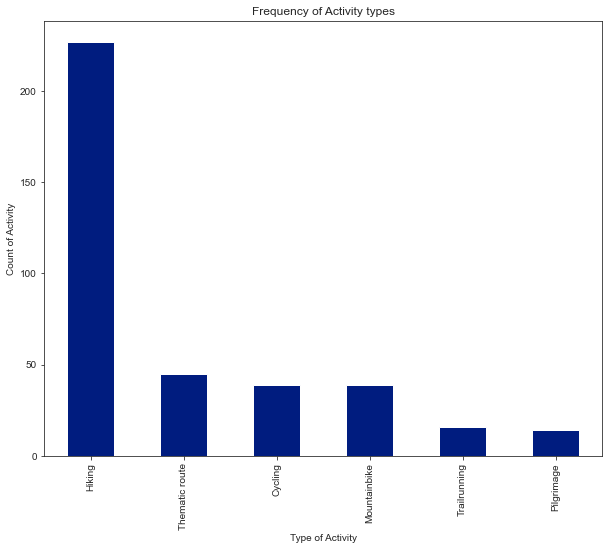

In [53]:
ax = analysis['sport'].value_counts().plot(kind='bar')
plt.title('Frequency of Activity types')
plt.xlabel('Type of Activity')
plt.ylabel('Count of Activity');

How does the picture look like by level of difficulty?

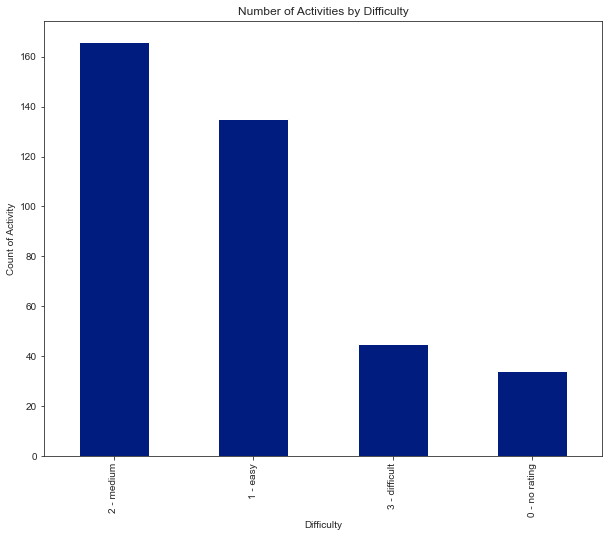

In [54]:
analysis['difficulty'].value_counts().plot(kind='bar')
plt.title('Number of Activities by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count of Activity');

### 3.4 Scatter Plot Visualization

The scatter plot paints an interesting picture of the trail data. First, the cycling trails are both the longest and the ones with most height difference out of the bunch. And second, it looks like all of the hiking trails fall between 2 and 20km (except for one). Perhaps this is because long distance hiking trails are considered to be "Pilgrimages"?

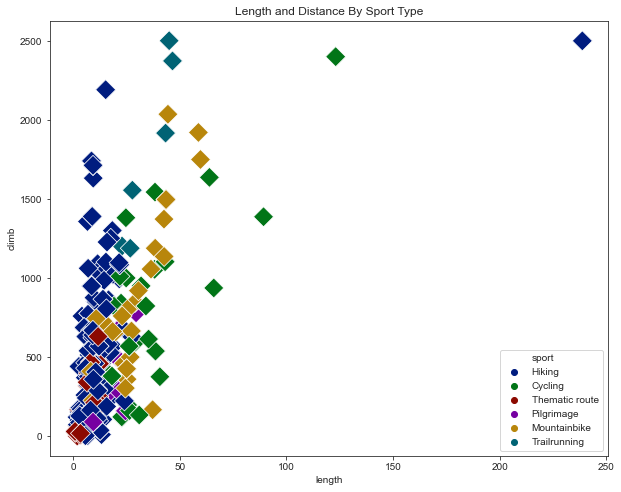

In [55]:
sns.scatterplot(    
    data=analysis,
    x="length", y="climb", hue='sport', 
    marker = "D", s=200, # set marker type and size
).set_title('Length and Distance By Sport Type')
plt.legend(loc='lower right'); # change default position of legend

In [56]:
# mean length for difficulty:
activities_df_br.groupby('difficulty').mean()

,ID,length,climb,min,max,technique,fitness
difficulty,,,,,,,
0 - no rating,334324.352941,24.856176,653.558824,792.823529,1261.352941,0.000000,0.000000
1 - easy,347464.840580,8.544058,240.594203,967.014493,1217.333333,1.434783,1.811594
2 - medium,392479.177143,16.708629,650.771429,1077.405714,1643.040000,2.548571,3.411429
3 - difficult,386033.716981,28.153585,1176.849057,978.207547,1904.509434,3.226415,5.226415


Now let's explore the data using only hiking trail data.

# 4 Analysis: Hiking Trails 

The primary interest of this analysis is hiking trail data. The following analysis will compare only hiking trails and drop the rest of the sport types.

In [57]:
hiking = activities_df_br[activities_df_br.sport == "Hiking"]
hiking.shape

(227, 11)

### 4.1 Scatter plot: Length and Distance of each Activity By Difficulty

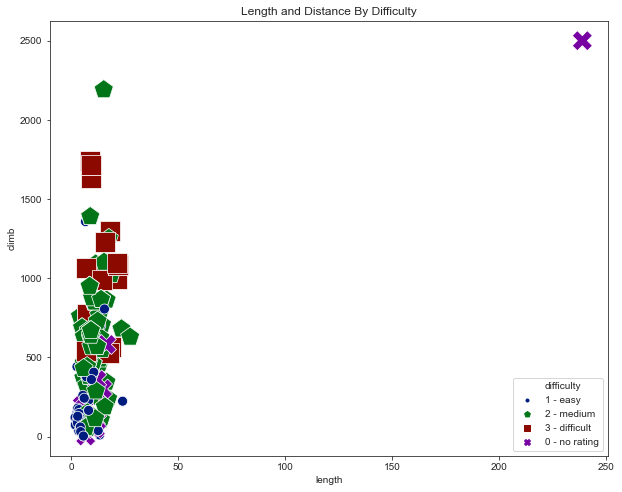

In [58]:
markers1 = {"1 - easy": ".", "2 - medium": "p",
           "3 - difficult":"s", "0 - no rating":"X"} #set the markers individually
sns.scatterplot(    
    data=hiking,
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], # rearrange order of the legend
    style='difficulty', markers = markers1, # set markers
    s = 400 # size of markers
).set_title('Length and Distance By Difficulty');

Seems we have one "outlier" which is more than 200km long. Let's remove it to get a better view on the majority of the trails.

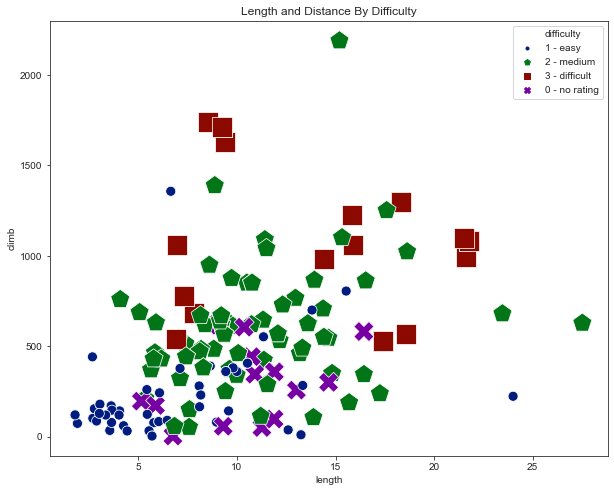

In [59]:
sns.scatterplot(    
    data=hiking[hiking.length < 200],
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], # rearrange order of the legend
    style='difficulty', markers = markers1, # set markers
    s = 400, # size of markers
).set_title('Length and Distance By Difficulty');

The easier trails seem to be shorter in length and with lower elevation gain. Let's see if there is a correlation.

### 4.2 Line Plot: Comparison of average Trail Length vs. Fitness Score

The following dataframe uses the fitness scores and compares them to the length of each trail. How correlated is the trail length to the fitness score? A new columns is added for average length. 

In [93]:
# calculating the count by Fitness level and the average length 
fitness_length_check = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()
fitness_length_check

,fitness,count,average_length
0,0,26,20.099231
1,1,19,5.763684
2,2,62,7.763226
3,3,51,10.140980
4,4,44,11.364545
5,5,20,15.044500
6,6,5,13.060000


The routes with no fitness rating seems quite long. Probably related to the outlier previously identified.
For further analysis let's remove the trails without any difficulty rating and check if there is a visual clue.

In [94]:
fitness_length = fitness_length_check[fitness_length_check['fitness'] != 0]
plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')
#sns.linewidth = 6
plt.show()

There seems to be a relationship indeed between fitness score and length of the hike but let's have a closer look.

### 4.3 Boxplots: Difficulty vs. Elevation Gain and Length

The following boxplots show how the trail data is distributed by difficulty catagory compared to both elevation gain and length. It's pretty clear that the relationship between elevation gain and difficulty is more meaningful than the relationship between distance and difficulty. My legs agree! 

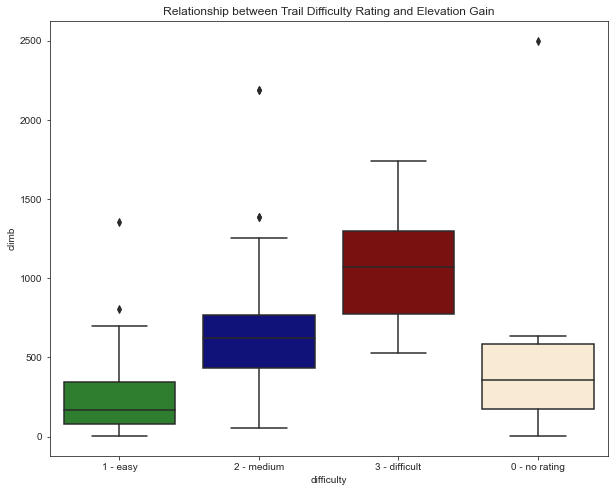

In [71]:
my_pal = {"1 - easy": "forestgreen", "2 - medium": "darkblue", "3 - difficult":"darkred", 
          "0 - no rating":"blanchedalmond"}
ax = sns.boxplot(x="difficulty", y="climb", data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Elevation Gain')\

# https://matplotlib.org/2.0.2/examples/color/named_colors.html

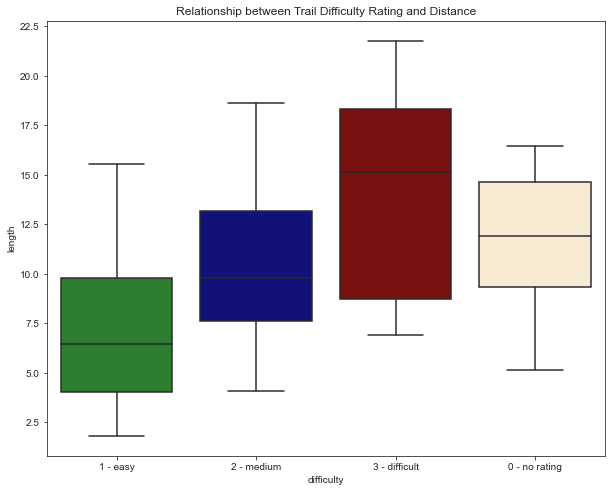

In [69]:
ax = sns.boxplot(x="difficulty", y="length",showfliers = False, data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Distance')

### 3.6 Correlation Matrix
Let's see what the mathematical correlations are between the four parameters: climb, length, fitness score, technique score. For that, trails without any rating will be excluded.

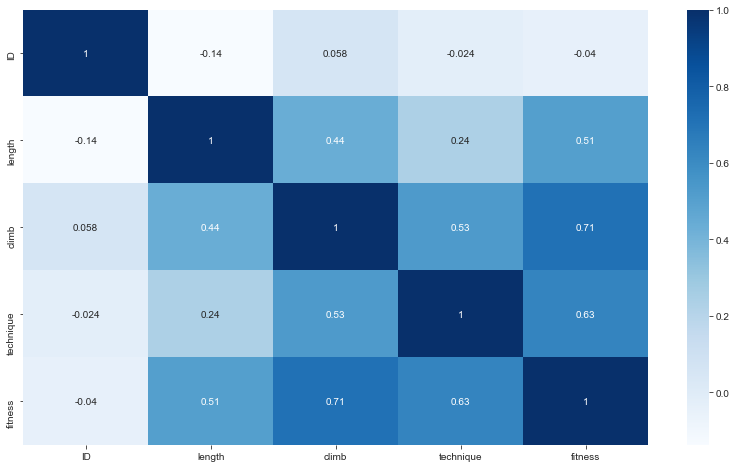

In [72]:
# remove numerical columns that are not needed and remove rows with no rating 
corr_matrix_df = hiking.drop(columns = ['min','max']).copy()
corr_matrix_df = corr_matrix_df[corr_matrix_df['difficulty'] != '0 - no rating']
# create a correlation matrix
corr_matrix = corr_matrix_df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues');

In [73]:
corr_matrix_df.head()

,ID,title,difficulty,sport,length,time,climb,technique,fitness
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,4,5
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,2,6
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,4,3
5,50213,Rellerli - Zum beliebten Ausflugsberg,2 - medium,Hiking,9.59,03:30,630,3,4
6,315061,Interlaken Ost - Harder Kulm,2 - medium,Hiking,4.09,02:30,759,2,3


'Fitness' and 'Technique' have the highest correlation among all measures.
What about the correlation with the 'Difficulty Level'?
We therefore convert the 'easy', 'medium', 'difficult' in numeric values and build a correlation matrix.

In [74]:
# add numerical column indicating the difficulty level
corr_matrix_df['difficulty_level'] = corr_matrix_df['difficulty']
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '1 - easy', ['difficulty_level']] = 1
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '2 - medium', ['difficulty_level']] = 2
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '3 - difficult', ['difficulty_level']] = 3

# the column 'difficulty_level' will return object type which we need to convert to integers.
corr_matrix_df['difficulty_level']= corr_matrix_df['difficulty_level'].astype(str).astype(int)
#or corr_matrix_df2 = pd.to_numeric(corr_matrix_df['difficulty_level']).astype(int)
corr_matrix_df2 = corr_matrix_df.copy()
corr_matrix_df2

,ID,title,difficulty,sport,length,time,climb,technique,fitness,difficulty_level
0,50431,Auf dem Jurahöhenweg,3 - difficult,Hiking,18.32,06:00,1300,4,5,3
1,131685,Via Alpina: Lenk - Gstaad,3 - difficult,Hiking,21.60,07:30,994,2,6,3
4,586723,Rundtour auf abenteuerlichen Wegen,2 - medium,Hiking,5.90,03:00,630,4,3,2
5,50213,Rellerli - Zum beliebten Ausflugsberg,2 - medium,Hiking,9.59,03:30,630,3,4,2
6,315061,Interlaken Ost - Harder Kulm,2 - medium,Hiking,4.09,02:30,759,2,3,2
...,...,...,...,...,...,...,...,...,...,...
391,795206,Uferweg Frutigen - Reichenbach,1 - easy,Hiking,5.70,01:20,3,0,1,1
393,441750,Um den Gelmersee zur Gelmerhütte,2 - medium,Hiking,9.14,03:39,640,3,4,2
395,439557,"Daytrip Bundalp, Kiental to Obere Dünde, Griesalp, Bundalp",2 - medium,Hiking,9.21,03:23,669,3,4,2
396,480409,Oeschinensee,1 - easy,Hiking,15.54,04:08,805,4,4,1


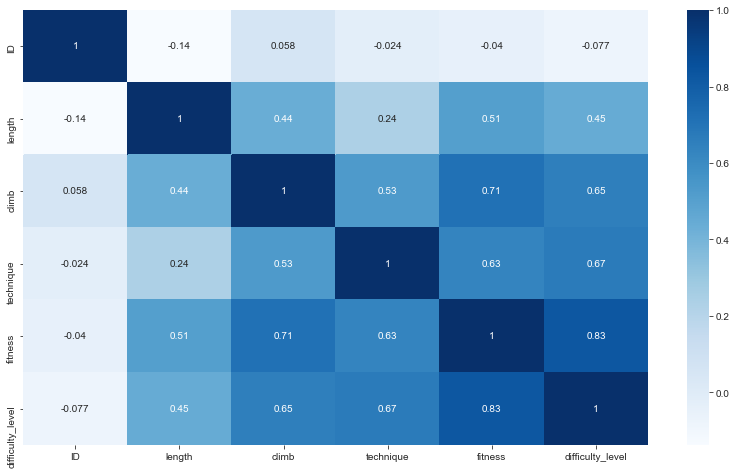

In [75]:
corr_matrix_level = corr_matrix_df2.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix_level, annot = True, cmap = 'Blues');

As we can see, the highest correlation is between the fitness level and the difficulty level, followed by the technique and the difficulty level. This was not visible in the box plot graphs above.

# 5 Download Trail GPS Data

The next part of this notebook deals with parsing HTML tags again, however this time around we will be gathering the GPS data needed to create the snowfall alert. The GPS data for each trail is actually a list of GPS points that comprise the length of the trail, from start to summit. However, we will only be using the first GPS point in our algorithm, which is the trail-head. 

The Bergfex website embedds their GPS data into downloadable files, which are meant to be uploaded to a GPS device for navigation purposes. As such, the following code will automatically download each GPS file into a folder. Importantly, a sleep timer is added to replicate how a human may download these files, if the sleep timer is not added, the website will become suspicious and prevent us from downloading more files. 

The type of GPS file that is being downloaded is a "GPX" or "GPS Exchange Format" file, which is a special type of XML file that can be used to describe waypoints. 

Finally, we crosscheck with Google Earth Web App, that our downloaded GPS data is exactly what we want.

### 5.1 Download Batches of GPX Files

This loop uses the hike id's to navigate to each of the hike's pages. It then downloads the GPS file to the folder "gpx_files" and saves it as a filename "Unique hike id.gpx". To prevent being blocked from the page, we download the dat in small batches for all 400 activities.

In [76]:
# create a small subset of data for testing
test_id = corr_matrix_df.iloc[20:30,0]
for hike_id in test_id: 
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(hike_id)};fileType=kml"
    print(url_id)
    r = requests.get(url_id, allow_redirects=True)
    time.sleep(5) 
    write_link = ('../gpx_files/'+ str(hike_id) + ".gpx")
    # Replace kml files with your filename
    with open(write_link, 'wb') as f:
        f.write(r.content)

https://www.bergfex.com/downloads/gps/?type=&id=114256;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=454773;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=114250;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=445813;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=316230;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=50976;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=454773;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=70029;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=86144;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=131699;fileType=kml


Let's look at the content of one download. There are lots of data points of which the key data needs to be filtered out.

In [125]:
r.content

b'<?xml version="1.0" encoding="UTF-8"?>\n<gpx version="1.1" creator="GPSBabel - http://www.gpsbabel.org" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n  <metadata>\n    <time>2021-03-22T20:14:11.718Z</time>\n    <bounds minlat="46.627483000" minlon="7.388903000" maxlat="46.652821000" maxlon="7.447050000"/>\n  </metadata>\n  <trk>\n    <name>Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen</name>\n    <trkseg>\n      <trkpt lat="46.627483000" lon="7.389884000">\n        <ele>815.000000</ele>\n      </trkpt>\n      <trkpt lat="46.627586000" lon="7.389825000">\n        <ele>816.000000</ele>\n      </trkpt>\n      <trkpt lat="46.628269000" lon="7.388903000">\n        <ele>829.000000</ele>\n      </trkpt>\n      <trkpt lat="46.628826000" lon="7.390014000">\n        <ele>827.000000</ele>\n      </trkpt>\n      <trkpt lat="46.629128000" lon="7.391050000">\n        <ele>830.000000</ele>\n      </trkpt>\n      <trkpt lat="46.6294330

###  5.2 Extract Coordinates from GPX files

Now that the GPX files have been downloaded to a local file, we can loop through them and extract the important information, which is the latitude and the longitude of the trail start.

In [77]:
list_of_trails_list = []
list_of_files = glob.glob('*gpx')  
for hike_id in test_id: 
    trail_gps_list = []
    gpx = gpxpy.parse(open('../gpx_files/'+str(hike_id)+'.gpx', 'r'))
    trail_gps_list.append(hike_id)
    for track in gpx.tracks: 
        trail_name = track.name
        trail_gps_list.append(trail_name)
        for segment in track.segments: 
            for point in segment.points: 
              lat = point.latitude
              trail_gps_list.append(lat)
              lon = point.longitude
              trail_gps_list.append(lon) 
              break
        list_of_trails_list.append(trail_gps_list)

print(list_of_trails_list)

[[114256, 'Zur Hohwacht im Emmental', 46.938908, 7.785141], [454773, 'Bergtour Gross Siedelhorn - Uelistock', 46.548069, 8.27652], [114250, 'Höhenwanderung über den Metschstand im Simmental', 46.4533, 7.470244], [445813, 'Breitlauen - Berghütte Männdlenen', 46.659283, 7.895428], [316230, 'Kinderwagenrundweg Grimmialp', 46.565903, 7.479002], [50976, 'Rundwanderung Tellenburg Frutigen', 46.588905, 7.651083], [454773, 'Bergtour Gross Siedelhorn - Uelistock', 46.548069, 8.27652], [70029, 'Osterglocken am Chasseral', 47.153267, 7.177969], [86144, 'Waldhäusern - beliebtes Ausflugsziel im Emmental', 46.920147, 7.725922], [131699, 'Rinderberg - Hornberg - Horneggli', 46.50819, 7.35815]]


### 5.3  Create a Dataframe and save as CSV

Let's take a look at our data now that it has been extracted. It looks like everything has is working as intended. Each trail has a unique ID and latitude and longitude. This data can now be saved to a CSV file which will be used for the snow alert in the next notebook. 

In [78]:
trail_coords_df = pd.DataFrame(list_of_trails_list)
# name the columns
trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon']

In [79]:
trail_coords_df.to_csv('../data/trail_coords_df.csv', index=False)
coords_df = pd.read_csv('../data/trail_coords_df.csv')
coords_df

,trail_id,name,lat,lon
0,114256,Zur Hohwacht im Emmental,46.938908,7.785141
1,454773,Bergtour Gross Siedelhorn - Uelistock,46.548069,8.276520
2,114250,Höhenwanderung über den Metschstand im Simmental,46.453300,7.470244
3,445813,Breitlauen - Berghütte Männdlenen,46.659283,7.895428
4,316230,Kinderwagenrundweg Grimmialp,46.565903,7.479002
5,50976,Rundwanderung Tellenburg Frutigen,46.588905,7.651083
6,454773,Bergtour Gross Siedelhorn - Uelistock,46.548069,8.276520
7,70029,Osterglocken am Chasseral,47.153267,7.177969
8,86144,Waldhäusern - beliebtes Ausflugsziel im Emmental,46.920147,7.725922
9,131699,Rinderberg - Hornberg - Horneggli,46.508190,7.358150


### 5.4 Check GPS example

Let's test one ID (131699) with its coordinates (lat = 46.508190, lon = 7.358150) in Google Earth web app. It correctly displays the location. 

Bergfex GPS data:
- https://www.bergfex.com/downloads/gps/?type=&id=131699&fileType=kml

Google Earth web app:
- https://earth.google.com/web/search/46%2e508190+7%2e358150/@46.50819,7.35815,2006.43177272a,699.98943356d,35y,0h,45t,0r/data=ClYaLBImGb4Ts14MQUdAIeU_pN--bh1AKhI0Ni41MDgxOTAgNy4zNTgxNTAYAiABIiYKJAlWqScNN6A1QBFWqScNN6A1wBkg4Hxc5e7VPyFlaK6dDdtZwA

In [80]:
example = coords_df[coords_df['trail_id'] == 131699]
example

,trail_id,name,lat,lon
9,131699,Rinderberg - Hornberg - Horneggli,46.50819,7.35815


<IPython.core.display.Javascript object>


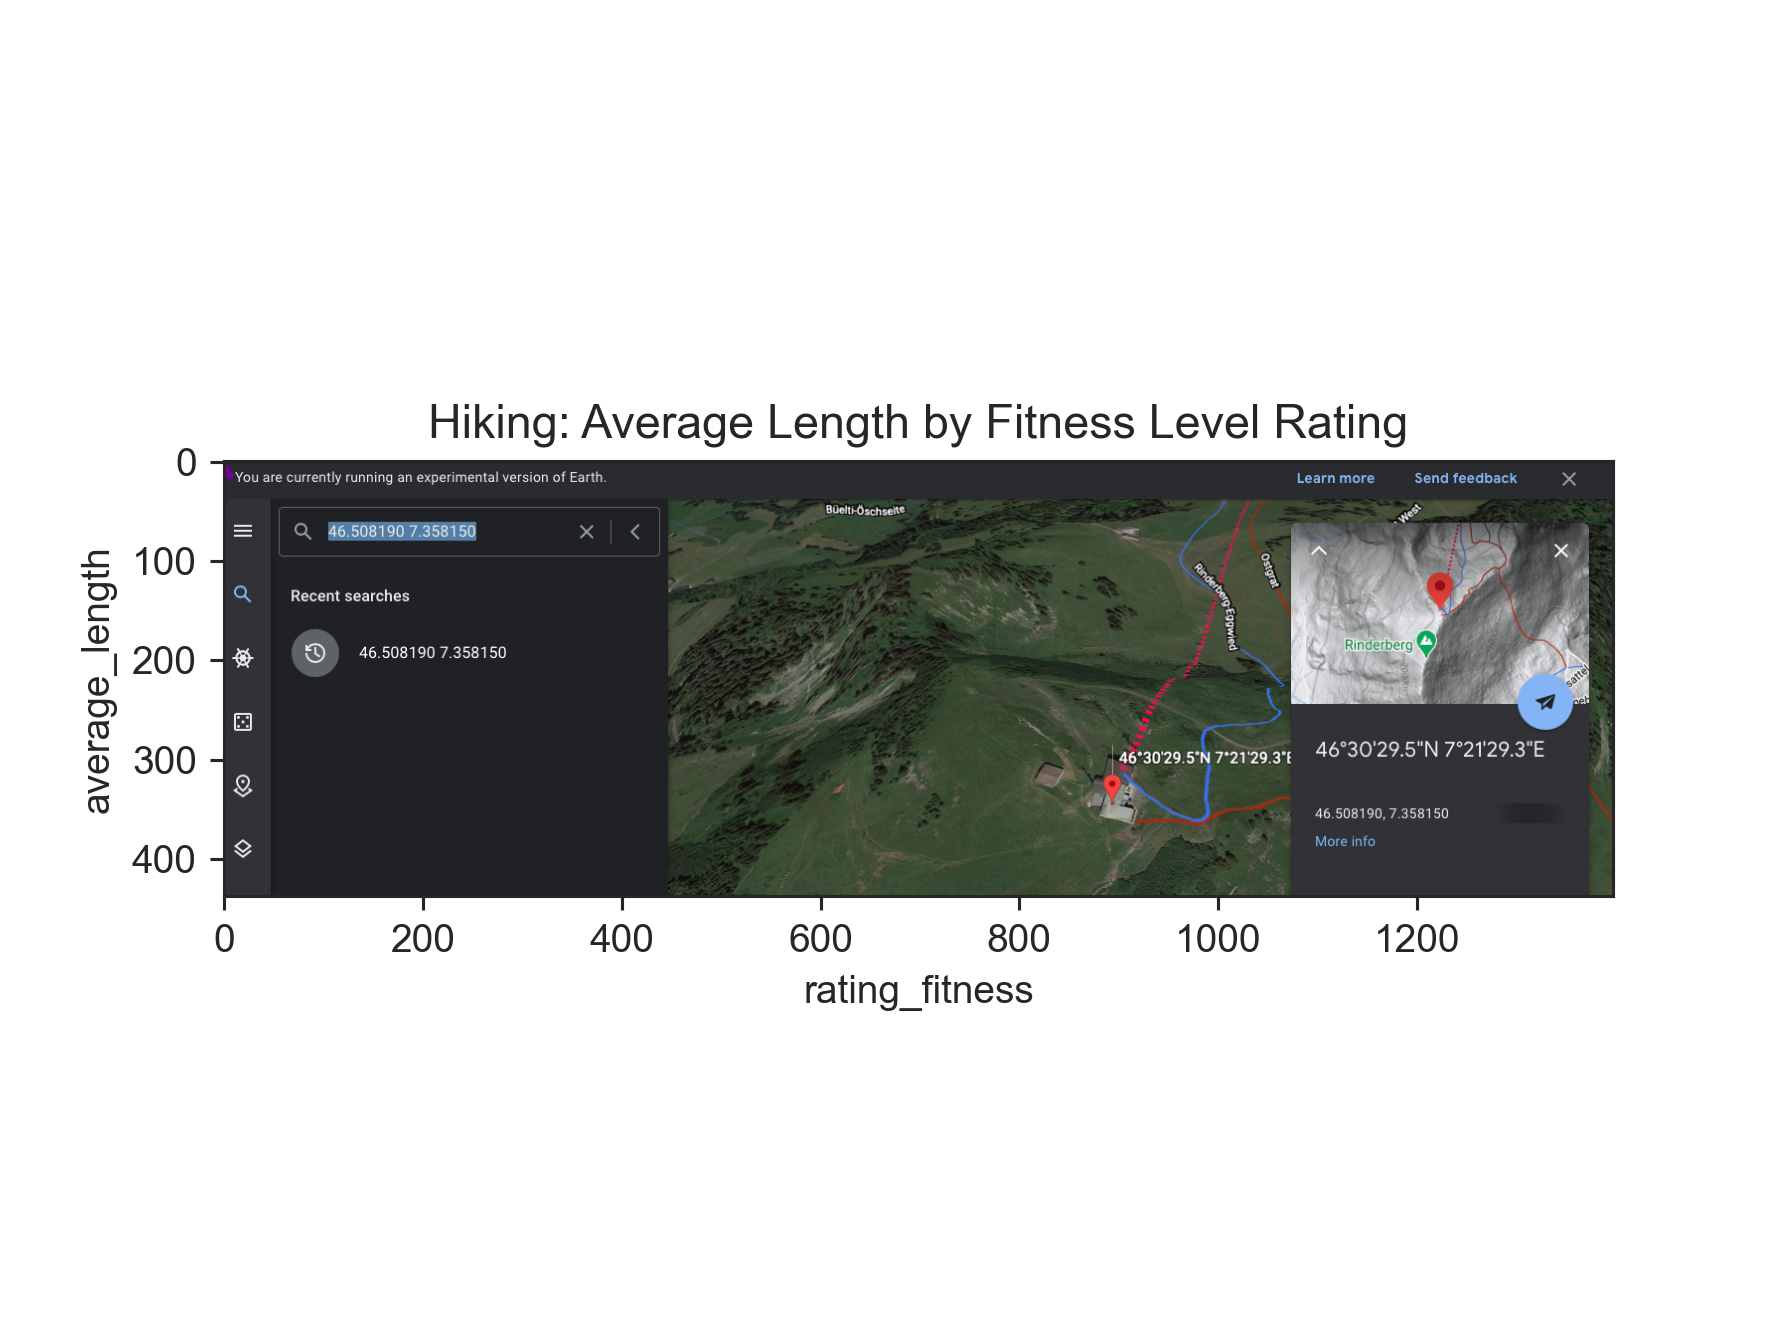

In [87]:
# needed to increase the display size of the png
%matplotlib notebook 
img = mpimg.imread('../GoogleEarth.png')
plt.rcParams['figure.dpi'] = 140
imgplot = plt.imshow(img)

### 5.5 Functions for GPS data

Now that we confirmed the GPS data, let's combine the code in a function.

In [88]:
def get_gpx_data(region, save_as_csv = True):
    for_gpx_df = pd.read_csv(f"../data/activities_{region}.csv")
    
    # download the gpx files for each trail_id
    ids_df = for_gpx_df.iloc[:,0]
    for ids in ids_df: 
        url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
        print(url_id)
        r = requests.get(url_id, allow_redirects=True)
        time.sleep(5) 
        write_link = ('../gpx_files/'+ str(ids) + ".gpx")
        # Replace files with your filename
        with open(write_link, 'wb') as f:
            f.write(r.content)

    # extract the trail_id, name of the hike, lat, lon from GPX files
    list_of_trails_list = []
    list_of_files = glob.glob('*gpx')  
    for ids in ids_df: 
        trail_gps_list = []
        gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r'))
        trail_gps_list.append(ids)
        for track in gpx.tracks: 
            trail_name = track.name
            trail_gps_list.append(trail_name)
            for segment in track.segments: 
                for point in segment.points: 
                  lat = point.latitude
                  trail_gps_list.append(lat)
                  lon = point.longitude
                  trail_gps_list.append(lon) 
                  break
            list_of_trails_list.append(trail_gps_list)

    # save to DF
    trail_coords_df = pd.DataFrame(list_of_trails_list)
    # name the columns
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon']
    # save to csv
    if save_as_csv == True:
        trail_coords_df.to_csv(f'../data/trail_coords_df_{region}.csv', index=False)
    return trail_coords_df

In [109]:
activities_df_br.ID.count()

400

In [111]:
tranch_size = 10
n_tranches = math.ceil(activities_df_br.ID.count() / tranch_size)
n_tranches

40

In [121]:
for_gpx_df_test = activities_df_br
list_of_trails_list_test = []
list_of_files_test = glob.glob('*gpx')  

ids_df_test = for_gpx_df_test.iloc[0:3,0]
for ids in ids_df_test: 
    # download the gpx files for each trail_id
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
    #print(url_id)
    r = requests.get(url_id, allow_redirects=True)
    time.sleep(5) 
    write_link = ('../gpx_files/'+ str(ids) + ".gpx") # Create gpx file
    with open(write_link, 'wb') as f:
        f.write(r.content)  # Input data for each ID in each file

    # extract the trail_id, name of the hike, lat, lon from GPX files
    trail_gps_list_test = [] # Create a list for each trail_id
    trail_gps_list_test.append(ids)
    gpx_test = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
    for track in gpx_test.tracks: 
        trail_name = track.name
        trail_gps_list_test.append(trail_name)
        for segment in track.segments: 
            for point in segment.points: 
              lat = point.latitude
              trail_gps_list_test.append(lat)
              lon = point.longitude
              trail_gps_list_test.append(lon) 
              break
        list_of_trails_list_test.append(trail_gps_list_test)

# save to DF
trail_coords_df_test = pd.DataFrame(list_of_trails_list_test)
# name the columns
trail_coords_df_test.columns=['trail_id', 'name', 'lat', 'lon']
# save to csv
#if save_as_csv == True:
trail_coords_df_test.to_csv(f'../data/trail_coords_df_test_test.csv', index=False)

In [124]:
r.content

b'<?xml version="1.0" encoding="UTF-8"?>\n<gpx version="1.1" creator="GPSBabel - http://www.gpsbabel.org" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n  <metadata>\n    <time>2021-03-22T20:14:11.718Z</time>\n    <bounds minlat="46.627483000" minlon="7.388903000" maxlat="46.652821000" maxlon="7.447050000"/>\n  </metadata>\n  <trk>\n    <name>Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen</name>\n    <trkseg>\n      <trkpt lat="46.627483000" lon="7.389884000">\n        <ele>815.000000</ele>\n      </trkpt>\n      <trkpt lat="46.627586000" lon="7.389825000">\n        <ele>816.000000</ele>\n      </trkpt>\n      <trkpt lat="46.628269000" lon="7.388903000">\n        <ele>829.000000</ele>\n      </trkpt>\n      <trkpt lat="46.628826000" lon="7.390014000">\n        <ele>827.000000</ele>\n      </trkpt>\n      <trkpt lat="46.629128000" lon="7.391050000">\n        <ele>830.000000</ele>\n      </trkpt>\n      <trkpt lat="46.6294330

In [122]:
trail_coords_df_test

,0,1,2,3
0,50431,Auf dem Jurahöhenweg,47.169090,7.258234
1,131685,Via Alpina: Lenk - Gstaad,46.457142,7.443128
2,717203,Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen,46.627483,7.389884


In [123]:
list_of_trails_list_test

[[50431, 'Auf dem Jurahöhenweg', 47.16909, 7.258234],
 [131685, 'Via Alpina: Lenk - Gstaad', 46.457142, 7.443128],
 [717203,
  'Boltigen - Feuersteini - Rossberg - Pfaffenried - Boltigen',
  46.627483,
  7.389884]]

In [ ]:
def get_gpx_data1(region, tranch_size, save_as_csv = True):
    for_gpx_df = pd.read_csv(f"../data/activities_{region}.csv")
    
    list_of_trails_list = []
    start_tranch = 0
    end_tranch = start_tranch + tranch_size
    
    n_tranches = math.ceil(activities_df.ID.count()/tranch_size)
    
    for T in range(n_tranches):
        # download the gpx files for each trail_id
        ids_df = for_gpx_df.iloc[start_tranch:end_tranch,0]
        for ids in ids_df: 
            url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
            print(url_id)
            r = requests.get(url_id, allow_redirects=True)
            time.sleep(5) 
            write_link = ('../gpx_files/'+ str(ids) + ".gpx")
            # Replace kml files with your filename
            with open(write_link, 'wb') as f:
                f.write(r.content)

        # extract the trail_id, name of the hike, lat, lon from GPX files
        list_of_files = glob.glob('*gpx')  
        for ids in ids_df: 
            trail_gps_list = []
            gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r'))
            trail_gps_list.append(ids)
            for track in gpx.tracks: 
                trail_name = track.name
                trail_gps_list.append(trail_name)
                for segment in track.segments: 
                    for point in segment.points: 
                      lat = point.latitude
                      trail_gps_list.append(lat)
                      lon = point.longitude
                      trail_gps_list.append(lon) 
                      break
                list_of_trails_list.append(trail_gps_list)
        start_tranch = start_tranch + tranch_size - 1 
        end_tranch = start_tranch + tranch_size
    
    # save to DF
    trail_coords_df = pd.DataFrame(list_of_trails_list)
    # name the columns
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon']
    # save to csv
    if save_as_csv == True:
        trail_coords_df.to_csv(f'../data/trail_coords_df_{region}.csv', index=False)
    return trail_coords_df

In [ ]:
def test_loop():
    

Let's test it with our 'Wallis' test region.

In [89]:
region_test2 = 'wallis'
n_pages_test2 = 2
result_test2 = preprocess(region_test2, n_pages_test2,save_as_csv = True)
gpx_data = get_gpx_data(region_test2, save_as_csv = True)
gpx_data.head()

scraped page 1
scraped page 2
number of tours collected: 40
https://www.bergfex.com/downloads/gps/?type=&id=6830;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=14412;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=229741;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=15205;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=707118;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=85392;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=91010;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=86825;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=120661;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=120720;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=51817;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=682755;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=1006133;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=586332;fileType

,trail_id,name,lat,lon
0,6830,Staudamm Mattmark - Distelalp - Tälliboden - Ofental - Staudamm Mattmark,46.050121,7.963843
1,14412,Gebirgswald Rundgang,46.399502,7.772404
2,229741,Sommer Gommerlauf - Junioren 6km,46.499458,8.301469
3,15205,Rundwanderung Hockuchriz,46.411285,7.774283
4,707118,Rundwanderung von der Fiescheralp durch den Tälligrattunel zur Märjela und zum Gletscherrand,46.413502,8.103486


# CONTINUE IN NOTEBOOK II